#### Prophet
<a id="prophet"></a>

Prophet is a forecasting tool developed by Meta  designed to make predictions for time series data with strong seasonal patterns and missing data points.

This model captures weekly and holiday seasonality for each sales metric and uses feature selection to capture strongly correlated variables to improve model performance.

Each sales metric section shows RMSE and MAE for test stores.

Training and Testing the model doesn't take much time, less than five minutes.

Running the cross-validation for the Prophet models takes forty minutes.

In [2]:
# Installing Dependencies
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Loading data
# File paths
time_series = "/Users/pablozarate/Documents/MSBA/Maverick/time_series_data_msba.csv"
qual_data = '/Users/pablozarate/Documents/MSBA/Maverick/qualitative_data_msba.csv'
data_sales = pd.read_csv(time_series)
data_stores = pd.read_csv(qual_data)

#Merging the datasets
df = data_stores.merge(data_sales, how = 'inner', on=['site_id_msba'])
pd.set_option('display.max_columns', None)
# df.head()

# Loading national gas/diesel prices data
unleaded_prices = "/Users/pablozarate/Documents/MSBA/Maverick/gas_prices.xls"
diesel_prices = "/Users/pablozarate/Documents/MSBA/Maverick/diesel_prices.xls"
natl_unleaded = pd.read_excel(unleaded_prices, sheet_name=1)
natl_diesel = pd.read_excel(diesel_prices, sheet_name = 1)

pd.set_option('display.max_columns', None)
# natl_unleaded.head()
# natl_diesel.head()

# Skip the first two rows and rename
natl_unleaded_cleaned = natl_unleaded.iloc[2:].reset_index(drop=True)
natl_unleaded_cleaned.columns = ['Date', 'Unleaded Price']
natl_diesel_cleaned = natl_diesel.iloc[2:].reset_index(drop=True)
natl_diesel_cleaned.columns = ['Date', 'Diesel Price']

#Converting date to datetime
natl_unleaded_cleaned['Date'] = pd.to_datetime(natl_unleaded_cleaned['Date'])
natl_diesel_cleaned['Date'] = pd.to_datetime(natl_diesel_cleaned['Date'])

# Define your start date
start_date = pd.Timestamp('2021-01-11')
end_date = pd.Timestamp('2023-08-16')

# Filter the DataFrames
unleaded_filtered_data = natl_unleaded_cleaned[(natl_unleaded_cleaned['Date'] >= start_date) & (natl_unleaded_cleaned['Date'] <= end_date)]
diesel_filtered_data = natl_diesel_cleaned[(natl_diesel_cleaned['Date'] >= start_date) & (natl_diesel_cleaned['Date'] <= end_date)]

# Replacing nulls with None
cols_to_fill = ['rv_lanes_layout', 'rv_lanes_stack_type', 'hi_flow_lanes_layout','hi_flow_lanes_stack_type','hi_flow_rv_lanes_layout', 
                'hi_flow_rv_lanes_stack_type', 'traditional_forecourt_stack_type'
               ]
for col_name in cols_to_fill:
    df[col_name].fillna("None", inplace=True)
    
# Dropping irrelevant columns
df = df.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis = 1)
cols_drop = ['front_door_count','godfather_s_pizza','diesel_x','non_24_hour','self_check_out','car_wash', 'ev_charging']
df = df.drop(columns=cols_drop)

# Converting date to datetime
df['calendar.calendar_day_date'] = pd.to_datetime(df['calendar.calendar_day_date'])
df['capital_projects.soft_opening_date'] = pd.to_datetime(df['capital_projects.soft_opening_date'])

# Removing data for site id 21980, has exceptionally high diesel sales
df = df[df['site_id_msba'] != 21980]

# Convert object columns to category
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype('category')

# List to hold one-hot encoded DataFrames
one_hot_encoded_dfs = []

# One-Hot Encoding for Prophet
categorical_columns = ['pizza', 'rv_lanes', 'def', 'rv_lanes_layout', 'hi_flow_lanes', 'hi_flow_rv_lanes', 'lottery', 'freal',
                       'bonfire_grill', 'cinnabon', 'ethanol_free', 'cat_scales', 'rv_dumps', 'propane',
                       'traditional_forecourt_layout', 'traditional_forecourt_stack_type', 'rv_lanes_stack_type', 'hi_flow_lanes_layout',
                       'hi_flow_lanes_stack_type', 'hi_flow_rv_lanes_layout', 'hi_flow_rv_lanes_stack_type'
                       ]

for column in categorical_columns:
    # Get the one-hot encoded DataFrame for the current column
    one_hot = pd.get_dummies(df[column], prefix=column)
    # Add the one-hot encoded DataFrame to the list
    one_hot_encoded_dfs.append(one_hot)
    # Drop the original categorical column from the DataFrame
    df = df.drop(column, axis=1)

# Join all one-hot encoded DataFrames with the original DataFrame
df = pd.concat([df] + one_hot_encoded_dfs, axis=1)

# Renaming msba site id to store id for Prophet
df.rename(columns={'site_id_msba': 'store_id'}, inplace=True)
df.rename(columns={'calendar.calendar_day_date': 'ds'}, inplace=True)

merged_df_unleaded = pd.merge(df, unleaded_filtered_data, left_on='ds', right_on='Date', how='left')
final_merged_df = pd.merge(merged_df_unleaded, diesel_filtered_data, left_on='ds', right_on='Date', how='left')
final_merged_df.drop(columns=['Date_y', 'Date_x'], inplace=True)
final_merged_df.sort_values(by='ds', inplace=True)

final_merged_df['Unleaded Price'] = final_merged_df['Unleaded Price'].ffill()
final_merged_df['Diesel Price'] = final_merged_df['Diesel Price'].ffill()

# Define the date range
start_date = pd.Timestamp('2021-01-11')
end_date = pd.Timestamp('2021-01-17')

# Filter the DataFrame for the specified date range
date_range_filter = (final_merged_df['ds'] >= start_date) & (final_merged_df['ds'] <= end_date)

# Manually set the Diesel and Unleaded Prices for this date range
final_merged_df.loc[date_range_filter, 'Diesel Price'] = 2.67
final_merged_df.loc[date_range_filter, 'Unleaded Price'] = 2.379

final_merged_df = final_merged_df.sort_values(by='ds', ascending=True)
df = final_merged_df

# Seasons
def is_spring(date):
    return pd.Timestamp(year=date.year, month=3, day=1) <= date <= pd.Timestamp(year=date.year, month=5, day=31)

def is_summer(date):
    return pd.Timestamp(year=date.year, month=6, day=1) <= date <= pd.Timestamp(year=date.year, month=8, day=31)

def is_fall(date):
    return pd.Timestamp(year=date.year, month=9, day=1) <= date <= pd.Timestamp(year=date.year, month=11, day=30)

def is_winter(date):
    year_end = pd.Timestamp(year=date.year, month=12, day=31)
    year_start = pd.Timestamp(year=date.year, month=1, day=1)
    if date.year % 4 == 0 and (date.year % 100 != 0 or date.year % 400 == 0):  # Leap year
        feb_end = pd.Timestamp(year=date.year, month=2, day=29)
    else:  # Non-leap year
        feb_end = pd.Timestamp(year=date.year, month=2, day=28)
    return pd.Timestamp(year=date.year, month=12, day=1) <= date <= year_end or year_start <= date <= feb_end

# Apply these functions to create season columns in your DataFrame
df['is_spring'] = df['ds'].apply(is_spring)
df['is_summer'] = df['ds'].apply(is_summer)
df['is_fall'] = df['ds'].apply(is_fall)
df['is_winter'] = df['ds'].apply(is_winter)

In [3]:
# If 'open_year' is in datetime format
df['open_year'] = pd.to_datetime(df['open_year'])
df['open_year'] = df['open_year'].dt.year
df['store_age'] = df['ds'].dt.year - df['open_year']
# Handling negative ages
df['store_age'] = df['store_age'].clip(lower=0)

In [5]:
for store_id in df['store_id'].unique():
    df[f'soft_opening_{store_id}'] = np.where((df['store_id'] == store_id) & 
                                              (df['ds'] == df['capital_projects.soft_opening_date']), 1, 0)


In [6]:
# Segmenting dataframes by sales metric for Prophet
prophet_df_unleaded = df[['store_id', 'ds', 'unleaded', 'calendar_information.holiday', 'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 
                          'x1_2_mile_income', 'x5_min_pop', 'x5_min_emp','x5_min_inc','x7_min_pop', 'x7_min_emp', 'x7_min_inc', 'open_year', 'womens_sink_count',
                          'pizza_No', 'pizza_Yes', 'rv_lanes_No', 'rv_lanes_Yes', 'def_No', 'def_Yes', 'rv_lanes_layout_In-Line', 'rv_lanes_layout_None', 
                          'rv_lanes_layout_Stack', 'hi_flow_lanes_No', 'hi_flow_lanes_Yes', 'hi_flow_rv_lanes_No', 'hi_flow_rv_lanes_Yes','is_spring', 'is_summer',
                          'is_fall', 'is_winter', 'hi_flow_lanes_fueling_positions', 'mens_urinal_count', 'mens_toilet_count', 'Unleaded Price', 'Diesel Price'
                       , 'square_feet', 'years_since_last_project', 'parking_spaces', 'traditional_forecourt_fueling_positions', 'rv_lanes_fueling_positions'
                       , 'womens_toilet_count', 'lottery_Yes', 'lottery_No', 'freal_Yes', 'freal_No', 'bonfire_grill_Yes', 'bonfire_grill_No', 'propane_Yes', 'propane_No'
                  ,'cinnabon_Yes', 'cinnabon_No', 'ethanol_free_Yes', 'ethanol_free_No', 'cat_scales_Yes', 'cat_scales_No', 'rv_dumps_Yes', 'rv_dumps_No',
                        'traditional_forecourt_layout_Stack', 'traditional_forecourt_layout_In-Line', 'traditional_forecourt_stack_type_Large',  'traditional_forecourt_stack_type_None', 'traditional_forecourt_stack_type_Extra-Large' 
                        ,'rv_lanes_stack_type_HF/RV', 'rv_lanes_stack_type_None', 'hi_flow_lanes_layout_Stack', 'hi_flow_lanes_layout_Combo','hi_flow_lanes_layout_None', 'hi_flow_lanes_stack_type_HF/RV', 'hi_flow_lanes_stack_type_None'
                        , 'hi_flow_rv_lanes_layout_Combo', 'hi_flow_rv_lanes_layout_In-Line', 'hi_flow_rv_lanes_layout_None', 'hi_flow_rv_lanes_layout_Stack', 'hi_flow_rv_lanes_stack_type_HF/RV', 'hi_flow_rv_lanes_stack_type_None'
, 'store_age', 'soft_opening_21560', 'soft_opening_22015', 'soft_opening_22085', 'soft_opening_22330', 'soft_opening_22785', 'soft_opening_22540', 'soft_opening_22715', 'soft_opening_22750', 'soft_opening_22820', 'soft_opening_23135', 
'soft_opening_22855', 'soft_opening_22925', 'soft_opening_23450', 'soft_opening_22505', 'soft_opening_22645', 'soft_opening_23380', 'soft_opening_22260', 'soft_opening_22575', 'soft_opening_23485', 'soft_opening_22400', 'soft_opening_22120', 
'soft_opening_23345', 'soft_opening_23730', 'soft_opening_23240', 'soft_opening_22680', 'soft_opening_23660', 'soft_opening_23415', 'soft_opening_23835', 'soft_opening_23765', 'soft_opening_23905', 'soft_opening_24535', 'soft_opening_23555', 
'soft_opening_24220', 'soft_opening_22890', 'soft_opening_24255', 'soft_opening_24150'
]].copy()
prophet_df_unleaded.rename(columns={'unleaded': 'y'}, inplace=True)

prophet_df_diesel = df[['store_id', 'ds', 'diesel_y', 'calendar_information.holiday', 'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 
                          'x1_2_mile_income', 'x5_min_pop', 'x5_min_emp','x5_min_inc','x7_min_pop', 'x7_min_emp', 'x7_min_inc', 'open_year', 'womens_sink_count',
                          'pizza_No', 'pizza_Yes', 'rv_lanes_No', 'rv_lanes_Yes', 'def_No', 'def_Yes', 'rv_lanes_layout_In-Line', 'rv_lanes_layout_None', 
                          'rv_lanes_layout_Stack', 'hi_flow_lanes_No', 'hi_flow_lanes_Yes', 'hi_flow_rv_lanes_No', 'hi_flow_rv_lanes_Yes','is_spring', 'is_summer',
                          'is_fall', 'is_winter', 'hi_flow_lanes_fueling_positions', 'mens_urinal_count', 'mens_toilet_count', 'Unleaded Price', 'Diesel Price'
                          , 'square_feet', 'years_since_last_project', 'parking_spaces', 'traditional_forecourt_fueling_positions', 'rv_lanes_fueling_positions'
                          , 'womens_toilet_count', 'lottery_Yes', 'lottery_No', 'freal_Yes', 'freal_No', 'bonfire_grill_Yes', 'bonfire_grill_No', 'propane_Yes', 'propane_No'
                          ,'cinnabon_Yes', 'cinnabon_No', 'ethanol_free_Yes', 'ethanol_free_No', 'cat_scales_Yes', 'cat_scales_No', 'rv_dumps_Yes', 'rv_dumps_No',
                          'traditional_forecourt_layout_Stack', 'traditional_forecourt_layout_In-Line', 'traditional_forecourt_stack_type_Large',  'traditional_forecourt_stack_type_None', 'traditional_forecourt_stack_type_Extra-Large' 
                        ,'rv_lanes_stack_type_HF/RV', 'rv_lanes_stack_type_None', 'hi_flow_lanes_layout_Stack', 'hi_flow_lanes_layout_Combo','hi_flow_lanes_layout_None', 'hi_flow_lanes_stack_type_HF/RV', 'hi_flow_lanes_stack_type_None'
                           , 'hi_flow_rv_lanes_layout_Combo', 'hi_flow_rv_lanes_layout_In-Line', 'hi_flow_rv_lanes_layout_None', 'hi_flow_rv_lanes_layout_Stack', 'hi_flow_rv_lanes_stack_type_HF/RV', 'hi_flow_rv_lanes_stack_type_None'
, 'store_age', 'soft_opening_21560', 'soft_opening_22015', 'soft_opening_22085', 'soft_opening_22330', 'soft_opening_22785', 'soft_opening_22540', 'soft_opening_22715', 'soft_opening_22750', 'soft_opening_22820', 'soft_opening_23135', 
'soft_opening_22855', 'soft_opening_22925', 'soft_opening_23450', 'soft_opening_22505', 'soft_opening_22645', 'soft_opening_23380', 'soft_opening_22260', 'soft_opening_22575', 'soft_opening_23485', 'soft_opening_22400', 'soft_opening_22120', 
'soft_opening_23345', 'soft_opening_23730', 'soft_opening_23240', 'soft_opening_22680', 'soft_opening_23660', 'soft_opening_23415', 'soft_opening_23835', 'soft_opening_23765', 'soft_opening_23905', 'soft_opening_24535', 'soft_opening_23555', 
'soft_opening_24220', 'soft_opening_22890', 'soft_opening_24255', 'soft_opening_24150'
]].copy()
prophet_df_diesel.rename(columns={'diesel_y': 'y'}, inplace=True)

prophet_df_food_sales = df[['store_id', 'ds', 'daily_yoy_ndt.total_food_service', 'calendar_information.holiday', 'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 
                          'x1_2_mile_income', 'x5_min_pop', 'x5_min_emp','x5_min_inc','x7_min_pop', 'x7_min_emp', 'x7_min_inc', 'open_year', 'womens_sink_count',
                          'pizza_No', 'pizza_Yes', 'rv_lanes_No', 'rv_lanes_Yes', 'def_No', 'def_Yes', 'rv_lanes_layout_In-Line', 'rv_lanes_layout_None', 
                          'rv_lanes_layout_Stack', 'hi_flow_lanes_No', 'hi_flow_lanes_Yes', 'hi_flow_rv_lanes_No', 'hi_flow_rv_lanes_Yes','is_spring', 'is_summer',
                          'is_fall', 'is_winter', 'hi_flow_lanes_fueling_positions', 'mens_urinal_count', 'mens_toilet_count', 'Unleaded Price', 'Diesel Price'
                          , 'square_feet', 'years_since_last_project', 'parking_spaces', 'traditional_forecourt_fueling_positions', 'rv_lanes_fueling_positions'
                          , 'womens_toilet_count', 'lottery_Yes', 'lottery_No', 'freal_Yes', 'freal_No', 'bonfire_grill_Yes', 'bonfire_grill_No', 'propane_Yes', 'propane_No'
                          ,'cinnabon_Yes', 'cinnabon_No', 'ethanol_free_Yes', 'ethanol_free_No', 'cat_scales_Yes', 'cat_scales_No', 'rv_dumps_Yes', 'rv_dumps_No',
                          'traditional_forecourt_layout_Stack', 'traditional_forecourt_layout_In-Line', 'traditional_forecourt_stack_type_Large',  'traditional_forecourt_stack_type_None', 'traditional_forecourt_stack_type_Extra-Large' 
                        ,'rv_lanes_stack_type_HF/RV', 'rv_lanes_stack_type_None', 'hi_flow_lanes_layout_Stack', 'hi_flow_lanes_layout_Combo','hi_flow_lanes_layout_None', 'hi_flow_lanes_stack_type_HF/RV', 'hi_flow_lanes_stack_type_None'
                           , 'hi_flow_rv_lanes_layout_Combo', 'hi_flow_rv_lanes_layout_In-Line', 'hi_flow_rv_lanes_layout_None', 'hi_flow_rv_lanes_layout_Stack', 'hi_flow_rv_lanes_stack_type_HF/RV', 'hi_flow_rv_lanes_stack_type_None'
, 'store_age', 'soft_opening_21560', 'soft_opening_22015', 'soft_opening_22085', 'soft_opening_22330', 'soft_opening_22785', 'soft_opening_22540', 'soft_opening_22715', 'soft_opening_22750', 'soft_opening_22820', 'soft_opening_23135', 
'soft_opening_22855', 'soft_opening_22925', 'soft_opening_23450', 'soft_opening_22505', 'soft_opening_22645', 'soft_opening_23380', 'soft_opening_22260', 'soft_opening_22575', 'soft_opening_23485', 'soft_opening_22400', 'soft_opening_22120', 
'soft_opening_23345', 'soft_opening_23730', 'soft_opening_23240', 'soft_opening_22680', 'soft_opening_23660', 'soft_opening_23415', 'soft_opening_23835', 'soft_opening_23765', 'soft_opening_23905', 'soft_opening_24535', 'soft_opening_23555', 
'soft_opening_24220', 'soft_opening_22890', 'soft_opening_24255', 'soft_opening_24150'
]].copy()
prophet_df_food_sales.rename(columns={'daily_yoy_ndt.total_food_service': 'y'}, inplace=True)

prophet_df_inside_sales = df[['store_id', 'ds', 'daily_yoy_ndt.total_inside_sales', 'calendar_information.holiday', 'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 
                          'x1_2_mile_income', 'x5_min_pop', 'x5_min_emp','x5_min_inc','x7_min_pop', 'x7_min_emp', 'x7_min_inc', 'open_year', 'womens_sink_count',
                          'pizza_No', 'pizza_Yes', 'rv_lanes_No', 'rv_lanes_Yes', 'def_No', 'def_Yes', 'rv_lanes_layout_In-Line', 'rv_lanes_layout_None', 
                          'rv_lanes_layout_Stack', 'hi_flow_lanes_No', 'hi_flow_lanes_Yes', 'hi_flow_rv_lanes_No', 'hi_flow_rv_lanes_Yes','is_spring', 'is_summer',
                          'is_fall', 'is_winter', 'hi_flow_lanes_fueling_positions', 'mens_urinal_count', 'mens_toilet_count', 'Unleaded Price', 'Diesel Price'
                          , 'square_feet', 'years_since_last_project', 'parking_spaces', 'traditional_forecourt_fueling_positions', 'rv_lanes_fueling_positions'
                          , 'womens_toilet_count', 'lottery_Yes', 'lottery_No', 'freal_Yes', 'freal_No', 'bonfire_grill_Yes', 'bonfire_grill_No', 'propane_Yes', 'propane_No'
                          ,'cinnabon_Yes', 'cinnabon_No', 'ethanol_free_Yes', 'ethanol_free_No', 'cat_scales_Yes', 'cat_scales_No', 'rv_dumps_Yes', 'rv_dumps_No',
                          'traditional_forecourt_layout_Stack', 'traditional_forecourt_layout_In-Line', 'traditional_forecourt_stack_type_Large',  'traditional_forecourt_stack_type_None', 'traditional_forecourt_stack_type_Extra-Large' 
                        ,'rv_lanes_stack_type_HF/RV', 'rv_lanes_stack_type_None', 'hi_flow_lanes_layout_Stack', 'hi_flow_lanes_layout_Combo','hi_flow_lanes_layout_None', 'hi_flow_lanes_stack_type_HF/RV', 'hi_flow_lanes_stack_type_None'
                           , 'hi_flow_rv_lanes_layout_Combo', 'hi_flow_rv_lanes_layout_In-Line', 'hi_flow_rv_lanes_layout_None', 'hi_flow_rv_lanes_layout_Stack', 'hi_flow_rv_lanes_stack_type_HF/RV', 'hi_flow_rv_lanes_stack_type_None'
, 'store_age', 'soft_opening_21560', 'soft_opening_22015', 'soft_opening_22085', 'soft_opening_22330', 'soft_opening_22785', 'soft_opening_22540', 'soft_opening_22715', 'soft_opening_22750', 'soft_opening_22820', 'soft_opening_23135', 
'soft_opening_22855', 'soft_opening_22925', 'soft_opening_23450', 'soft_opening_22505', 'soft_opening_22645', 'soft_opening_23380', 'soft_opening_22260', 'soft_opening_22575', 'soft_opening_23485', 'soft_opening_22400', 'soft_opening_22120', 
'soft_opening_23345', 'soft_opening_23730', 'soft_opening_23240', 'soft_opening_22680', 'soft_opening_23660', 'soft_opening_23415', 'soft_opening_23835', 'soft_opening_23765', 'soft_opening_23905', 'soft_opening_24535', 'soft_opening_23555', 
'soft_opening_24220', 'soft_opening_22890', 'soft_opening_24255', 'soft_opening_24150'
]].copy()
prophet_df_inside_sales.rename(columns={'daily_yoy_ndt.total_inside_sales': 'y'}, inplace=True)

# Now creating a DataFrame for holidays for Prophet
holidays_df = df[df['calendar_information.holiday'].notnull()][['ds', 'calendar_information.holiday']].copy()
holidays_df.rename(columns={'calendar_information.holiday': 'holiday'}, inplace=True)
holidays_df = holidays_df.drop_duplicates()  # Ensure there are no duplicate holiday entries


In [7]:
# Define specific stores for testing
test_stores = [22540, 24535, 22750, 22015, 22260, 23905]

# Get all unique stores
unique_stores = df['store_id'].unique()

# Select stores for training (all stores not in the test set)
train_stores = [store for store in unique_stores if store not in test_stores]
print("Test stores:", test_stores)

# Define a function to split the data for each metric for Prophet
def split_data(prophet_df):
    train_data = prophet_df[prophet_df['store_id'].isin(train_stores)]
    test_data = prophet_df[prophet_df['store_id'].isin(test_stores)]
    return train_data, test_data

# Split by Train and Test for each metric for Prophet
train_unleaded, test_unleaded = split_data(prophet_df_unleaded)
train_diesel, test_diesel = split_data(prophet_df_diesel)
train_food_sales, test_food_sales = split_data(prophet_df_food_sales)
train_inside_sales, test_inside_sales = split_data(prophet_df_inside_sales)

Test stores: [22540, 24535, 22750, 22015, 22260, 23905]


In [8]:
# Training the model

from prophet import Prophet

# Models dictionary
models = {}

# Define the list of extra regressors you want to add.
extra_regressors = [
    # 'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 'x1_2_mile_income', 'x5_min_pop', 'x7_min_inc',
    'hi_flow_lanes_fueling_positions', 'mens_urinal_count', 'mens_toilet_count', 'womens_sink_count','x5_min_emp', 'x7_min_pop', 'x7_min_emp', 'open_year'
    ,'pizza_No', 'pizza_Yes', 'rv_lanes_No', 'rv_lanes_Yes', 'def_No', 'def_Yes', 'rv_lanes_layout_In-Line', 'rv_lanes_layout_None', 'rv_lanes_layout_Stack',
    'hi_flow_lanes_No', 'hi_flow_lanes_Yes', 'hi_flow_rv_lanes_No', 'hi_flow_rv_lanes_Yes'
    ]

# Define n_changepoints for each metric
n_changepoints_dict = {'unleaded': 4,
    'diesel': 5,
    'food_sales': 0,
    'inside_sales': 0
}

# Train models for each metric
for metric in ['unleaded', 'diesel', 'food_sales', 'inside_sales']:
    n_changepoints = n_changepoints_dict[metric]
    # Initialize the Prophet model with holidays
    model = Prophet(holidays=holidays_df, n_changepoints=n_changepoints, changepoint_prior_scale=0.2)
    # Add custom seasonalities
    model.add_seasonality(name='summer', period=365.25/4, fourier_order=6, condition_name='is_summer')
    model.add_seasonality(name='fall', period=365.25/4, fourier_order=6, condition_name='is_fall')      
    model.add_seasonality(name='winter', period=365.25/4, fourier_order=6, condition_name='is_winter')
    model.add_seasonality(name='spring', period=365.25/4, fourier_order=6, condition_name='is_spring')
    model.add_seasonality(name='weekly', period=7, fourier_order=3) 
    # Add each extra regressor to the model
    for regressor in extra_regressors:
        model.add_regressor(regressor)
    # Select the training data for the current metric
    train_data = globals()[f'train_{metric}']
    # Fit the model using both the 'ds', 'y', and the extra regressors
    model.fit(train_data[['ds', 'y'] + extra_regressors 
                         + ['is_spring', 'is_summer', 'is_fall', 'is_winter']
                         ])
    # Store the model in the dictionary
    models[metric] = model

22:53:46 - cmdstanpy - INFO - Chain [1] start processing
22:53:54 - cmdstanpy - INFO - Chain [1] done processing
22:54:00 - cmdstanpy - INFO - Chain [1] start processing
22:54:07 - cmdstanpy - INFO - Chain [1] done processing
22:54:10 - cmdstanpy - INFO - Chain [1] start processing
22:54:14 - cmdstanpy - INFO - Chain [1] done processing
22:54:18 - cmdstanpy - INFO - Chain [1] start processing
22:54:24 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Forecasting for Test Stores
# Dictionary to store forecasts
forecasts = {}

# Forecast for each metric and each store
for store_id in test_stores:
    for metric in ['unleaded', 'diesel', 'food_sales', 'inside_sales']:
        model = models[metric]
        # Select test data for the current store and metric
        test_data = globals()[f'test_{metric}']
        store_test_data = test_data[test_data['store_id'] == store_id]
        # Make sure that your future dataframe includes the regressor values
        # This assumes that the test data includes the same extra regressor columns as the training data
        future_regressors = store_test_data[extra_regressors 
                                            + ['is_spring', 'is_summer', 'is_fall', 'is_winter']
                                            ].reset_index(drop=True)
        future = model.make_future_dataframe(periods=len(store_test_data))
        future = future.merge(store_test_data[['ds']], on='ds', how='right')
        # Add the regressors to the future dataframe
        future = pd.concat([future, future_regressors], axis=1)
        # Forecast
        forecast = model.predict(future)
        # Store forecast with store ID and metric
        forecasts[(store_id, metric)] = forecast[['ds', 'yhat']]


In [11]:
# Creating Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Evaluation metrics dictionary
evaluation_metrics = {}

# Calculate RMSE and MAE for each store and each metric
for store_id in test_stores:
    for metric in ['unleaded', 'diesel', 'food_sales', 'inside_sales']:
        # Actual sales
        actual = globals()[f'test_{metric}'][globals()[f'test_{metric}']['store_id'] == store_id]['y']
        # Predicted sales
        predicted = forecasts[(store_id, metric)]['yhat']
        # Ensure the lengths of actual and predicted are the same
        min_length = min(len(actual), len(predicted))
        actual, predicted = actual.iloc[:min_length], predicted.iloc[:min_length]
        # Calculate RMSE and MAE
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        # Store in dictionary
        evaluation_metrics[(store_id, metric)] = {'RMSE': rmse, 'MAE': mae}

# Custom sort order
metric_order = {'inside_sales': 1, 'food_sales': 2, 'diesel': 3, 'unleaded': 4}

# Sorting function that uses the metric_order for sorting
def custom_metric_sort(store_metric):
    _, metric = store_metric
    return metric_order[metric]

# Sort the evaluation_metrics keys based on the custom metric order
sorted_metrics = sorted(evaluation_metrics.keys(), key=custom_metric_sort)

# Function to print the metrics for a given type
def print_metrics_for_type(metric_type):
    for store_metric in sorted_metrics:
        store_id, metric = store_metric
        if metric == metric_type:
            metrics = evaluation_metrics[store_metric]
            print(f'Store ID: {store_id} - Metric: {metric}\n\tRMSE: {metrics["RMSE"]:.2f}\n\tMAE: {metrics["MAE"]:.2f}\n')

def plot_actual_vs_predicted(actual, predicted, metric, store_id):
    plt.figure(figsize=(10, 5))
    plt.plot(actual.reset_index(drop=True), label='Actual')
    plt.plot(predicted.reset_index(drop=True), label='Predicted', alpha=0.7)
    plt.title(f'Actual vs Predicted - {metric.capitalize()} for Store {store_id}')
    plt.xlabel('Time')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()


##### Inside Sales
<a id="inside-sales-prophet"></a>

In [14]:
# WITH REGRESSORS
# Organized review of metrics by type
print("Inside Sales Metrics:")
print_metrics_for_type('inside_sales')

Inside Sales Metrics:
Store ID: 22540 - Metric: inside_sales
	RMSE: 531.69
	MAE: 387.43

Store ID: 24535 - Metric: inside_sales
	RMSE: 480.95
	MAE: 353.69

Store ID: 22750 - Metric: inside_sales
	RMSE: 1346.79
	MAE: 1185.99

Store ID: 22015 - Metric: inside_sales
	RMSE: 468.43
	MAE: 394.71

Store ID: 22260 - Metric: inside_sales
	RMSE: 489.80
	MAE: 403.25

Store ID: 23905 - Metric: inside_sales
	RMSE: 494.37
	MAE: 386.15



In [ ]:
# Plot actual vs. predicted for 'inside_sales' for each store
for store_id in test_stores:
    metric = 'inside_sales'
    actual = globals()[f'test_{metric}'][globals()[f'test_{metric}']['store_id'] == store_id]['y']
    predicted = forecasts[(store_id, metric)]['yhat']
    min_length = min(len(actual), len(predicted))
    actual, predicted = actual.iloc[:min_length], predicted.iloc[:min_length]
    plot_actual_vs_predicted(actual, predicted, metric, store_id)


##### Food Service
<a id="food-service-prophet"></a>

In [15]:
# WITH REGRESSORS
print("Food Sales Metrics:")
print_metrics_for_type('food_sales')

Food Sales Metrics:
Store ID: 22540 - Metric: food_sales
	RMSE: 158.94
	MAE: 125.70

Store ID: 24535 - Metric: food_sales
	RMSE: 135.77
	MAE: 108.38

Store ID: 22750 - Metric: food_sales
	RMSE: 335.67
	MAE: 301.88

Store ID: 22015 - Metric: food_sales
	RMSE: 106.06
	MAE: 83.86

Store ID: 22260 - Metric: food_sales
	RMSE: 166.07
	MAE: 141.89

Store ID: 23905 - Metric: food_sales
	RMSE: 171.28
	MAE: 141.36



In [ ]:
# Plot actual vs. predicted for 'food_sales' for each store
for store_id in test_stores:
    metric = 'food_sales'
    actual = globals()[f'test_{metric}'][globals()[f'test_{metric}']['store_id'] == store_id]['y']
    predicted = forecasts[(store_id, metric)]['yhat']
    min_length = min(len(actual), len(predicted))
    actual, predicted = actual.iloc[:min_length], predicted.iloc[:min_length]
    plot_actual_vs_predicted(actual, predicted, metric, store_id)


##### Diesel
<a id="diesel-prophet"></a>

In [13]:
#INCLUDE REGRESSORS
print("Diesel Sales Metrics:")
print_metrics_for_type('diesel')

Diesel Sales Metrics:
Store ID: 22540 - Metric: diesel
	RMSE: 451.19
	MAE: 357.81

Store ID: 24535 - Metric: diesel
	RMSE: 321.19
	MAE: 247.34

Store ID: 22750 - Metric: diesel
	RMSE: 756.00
	MAE: 645.82

Store ID: 22015 - Metric: diesel
	RMSE: 678.98
	MAE: 601.67

Store ID: 22260 - Metric: diesel
	RMSE: 391.43
	MAE: 333.28

Store ID: 23905 - Metric: diesel
	RMSE: 762.54
	MAE: 694.67



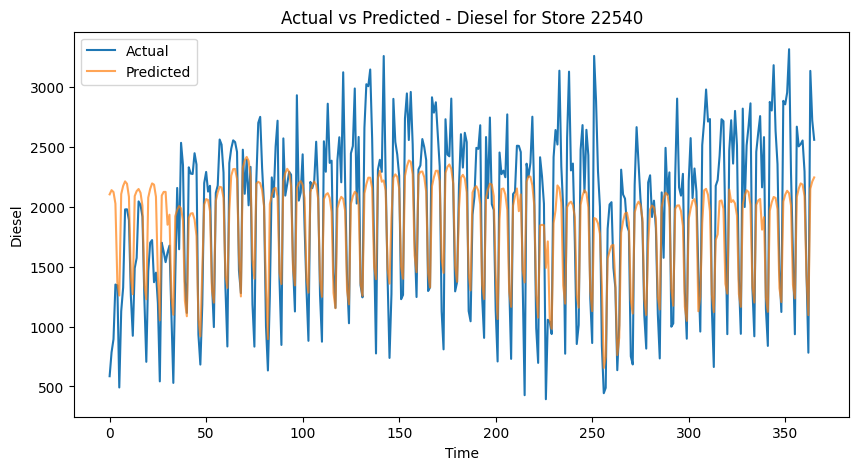

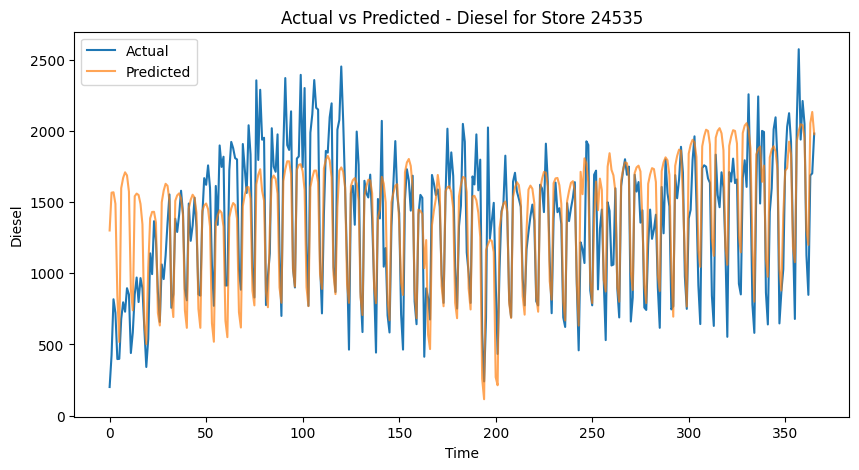

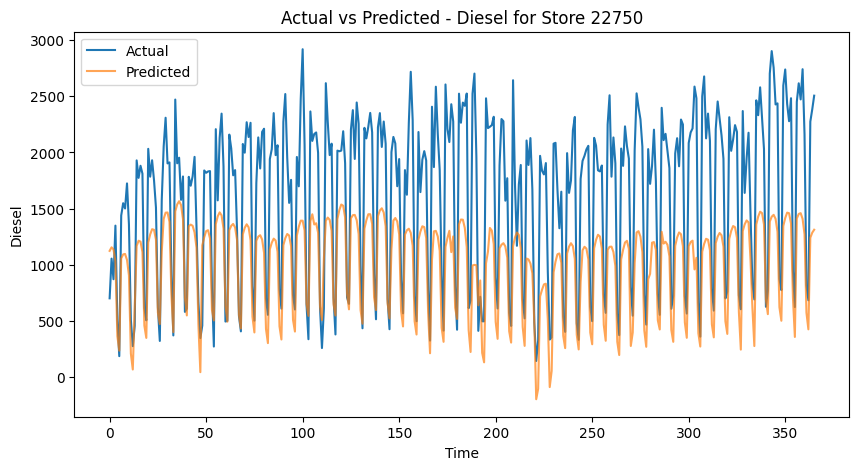

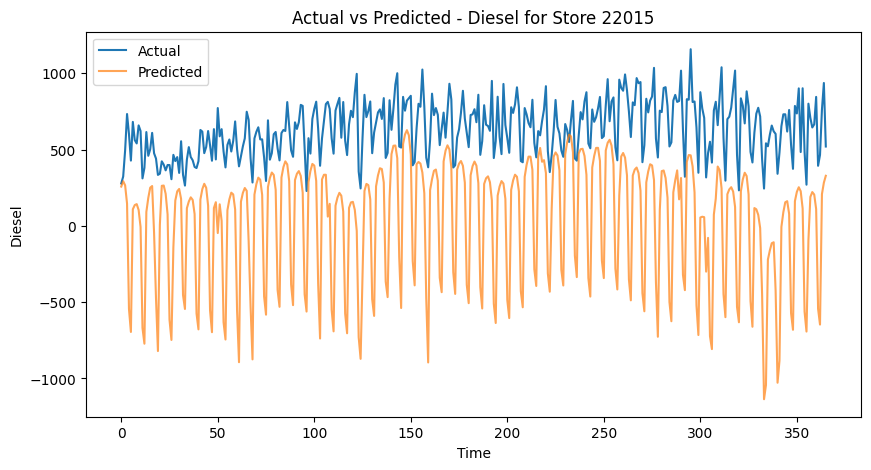

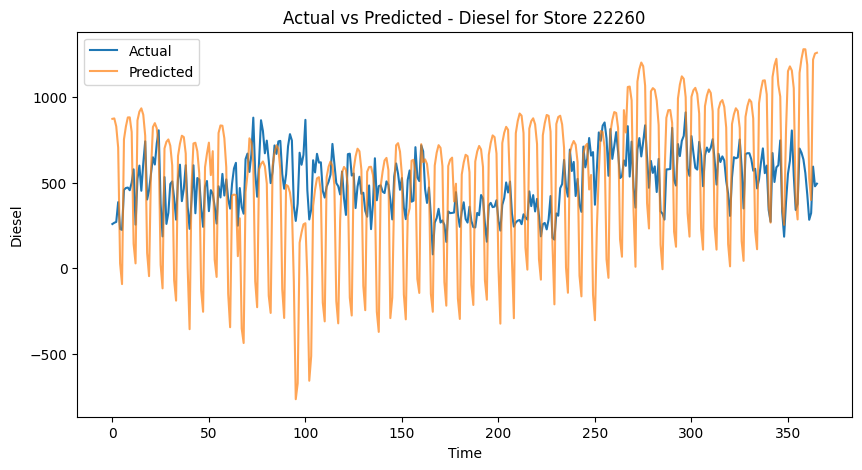

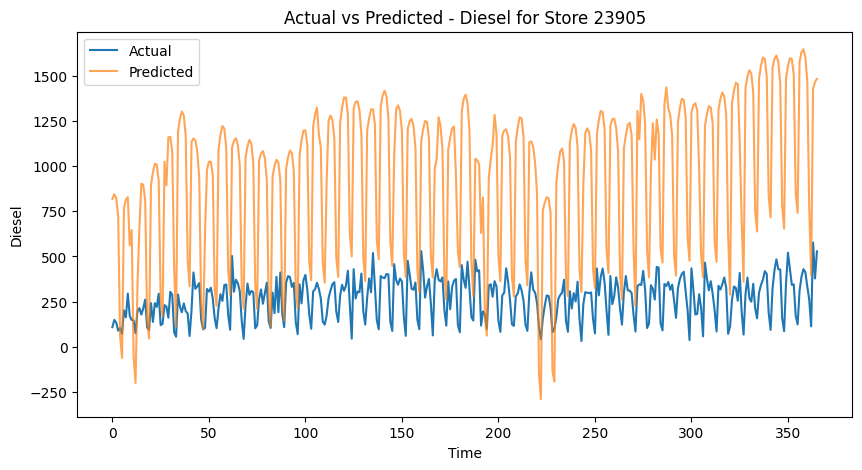

In [16]:
# Plot actual vs. predicted for 'diesel' for each store
for store_id in test_stores:
    metric = 'diesel'
    actual = globals()[f'test_{metric}'][globals()[f'test_{metric}']['store_id'] == store_id]['y']
    predicted = forecasts[(store_id, metric)]['yhat']
    min_length = min(len(actual), len(predicted))
    actual, predicted = actual.iloc[:min_length], predicted.iloc[:min_length]
    plot_actual_vs_predicted(actual, predicted, metric, store_id)


##### Unleaded
<a id="unleaded-prophet"></a>

In [19]:
# WITH REGRESSORS
print("Unleaded Sales Metrics:")
print_metrics_for_type('unleaded')

Unleaded Sales Metrics:
Store ID: 22540 - Metric: unleaded
	RMSE: 923.07
	MAE: 773.81

Store ID: 24535 - Metric: unleaded
	RMSE: 920.57
	MAE: 777.26

Store ID: 22750 - Metric: unleaded
	RMSE: 1275.31
	MAE: 1182.93

Store ID: 22015 - Metric: unleaded
	RMSE: 1586.38
	MAE: 1564.76

Store ID: 22260 - Metric: unleaded
	RMSE: 4657.58
	MAE: 4482.94

Store ID: 23905 - Metric: unleaded
	RMSE: 851.59
	MAE: 747.91



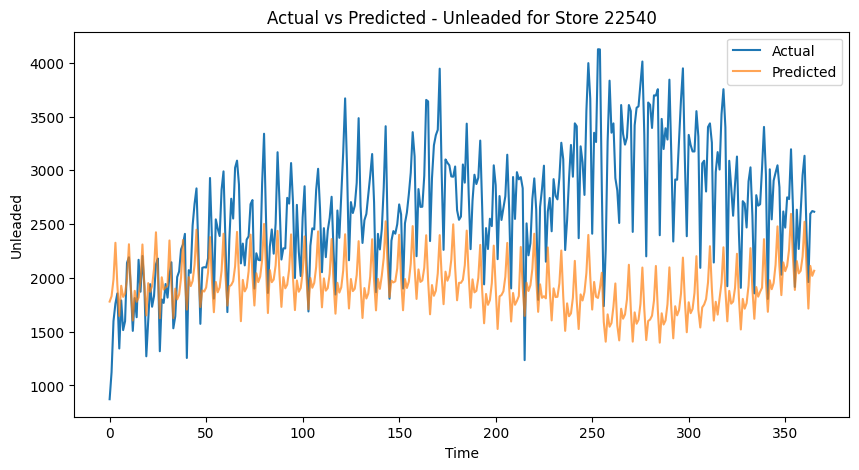

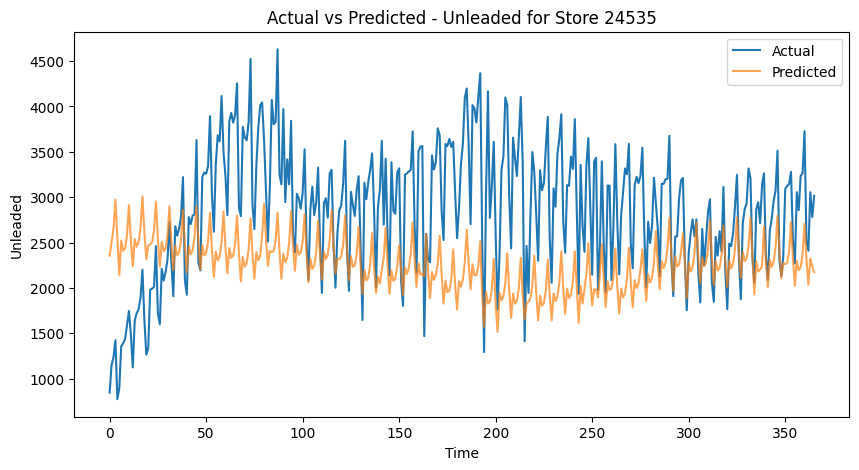

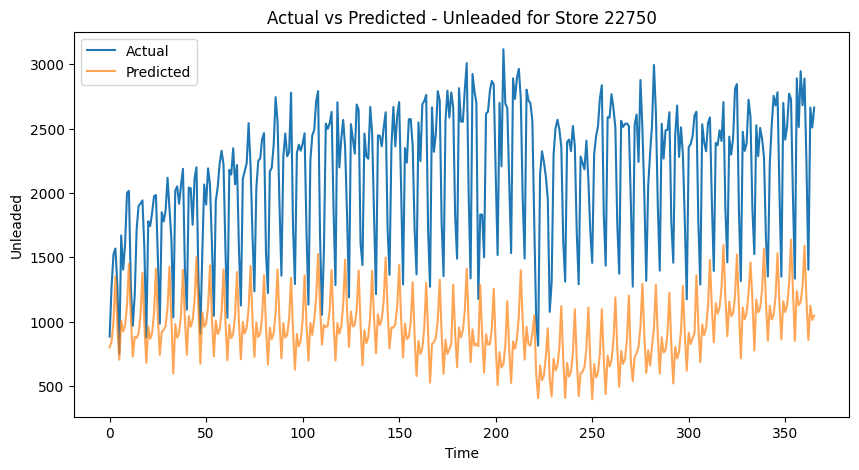

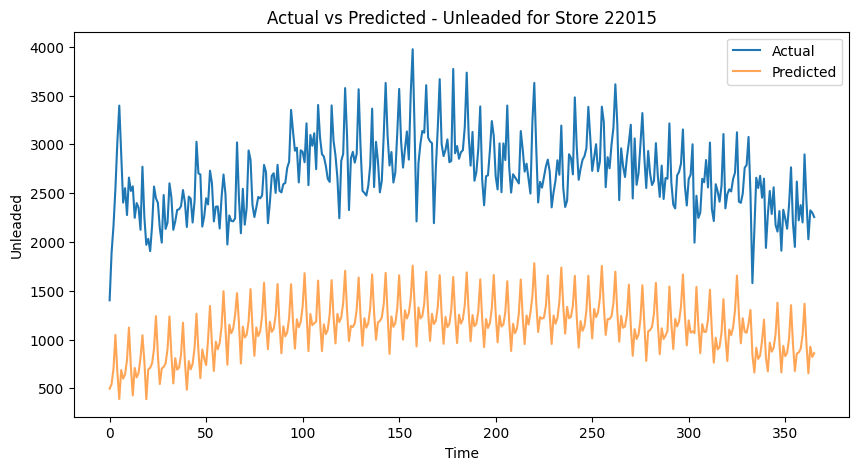

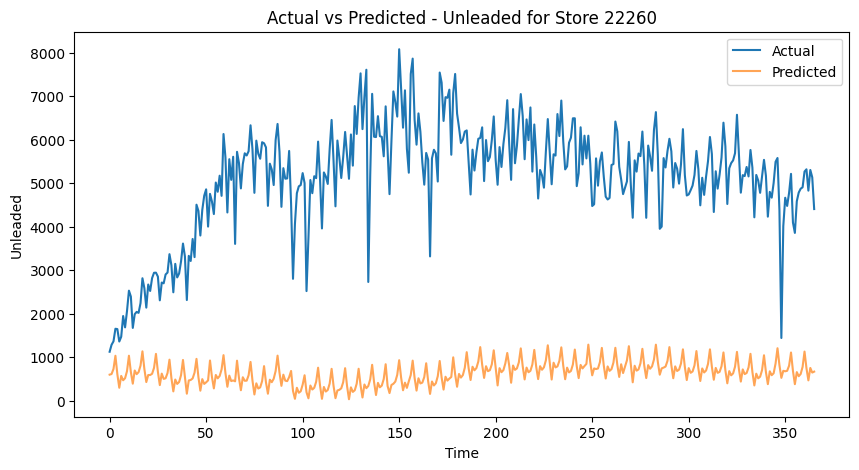

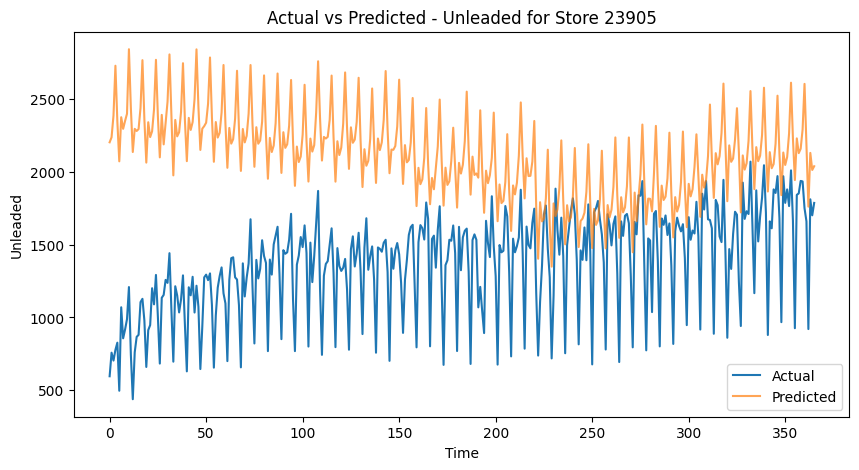

In [20]:
# Plot actual vs. predicted for 'unleaded' for each store
for store_id in test_stores:
    metric = 'unleaded'
    actual = globals()[f'test_{metric}'][globals()[f'test_{metric}']['store_id'] == store_id]['y']
    predicted = forecasts[(store_id, metric)]['yhat']
    min_length = min(len(actual), len(predicted))
    actual, predicted = actual.iloc[:min_length], predicted.iloc[:min_length]
    plot_actual_vs_predicted(actual, predicted, metric, store_id)

##### Cross-Validation
<a id="cross-validation"></a>

Cross-Validation for Prophet shows how the model would forecast daily sales for each metric over 365 days. Performance metrics are outlined below.

In [100]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet import Prophet

# Define the cross-validation function for Prophet
def cross_validate_prophet(data, initial, period, horizon, extra_regressors):
    # Initialize the Prophet model with holidays
    model = Prophet(holidays=holidays_df)
    # Add each extra regressor to the model
    for regressor in extra_regressors:
        model.add_regressor(regressor)
    # Fit the model using both the 'ds', 'y', and the extra regressors
    model.fit(data[['ds', 'y'] + extra_regressors])

    # Perform cross-validation
    df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)

    # Calculate performance metrics
    df_p = performance_metrics(df_cv)
    return df_p

# Define the initial training period, the period between cutoffs, and the forecast horizon
initial = '515 days'  # the first two years of data for training
period = '1 days'   # spacing between cutoff dates
horizon = '365 days'  # forecast horizon

# Create an empty dictionary to store performance metrics for each metric
cv_metrics = {}

# List of metrics
metrics = ['unleaded', 'diesel', 'food_sales', 'inside_sales']

# Loop through each metric to perform cross-validation
for metric in metrics:
    # Get the appropriate DataFrame
    data = globals()[f'prophet_df_{metric}']

    # Perform cross-validation and get performance metrics
    performance = cross_validate_prophet(data, initial, period, horizon, extra_regressors)

    # Store the performance metrics in the dictionary
    cv_metrics[metric] = performance

21:31:45 - cmdstanpy - INFO - Chain [1] start processing
21:31:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/67 [00:00<?, ?it/s]

21:31:54 - cmdstanpy - INFO - Chain [1] start processing
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:02 - cmdstanpy - INFO - Chain [1] done processing
21:32:07 - cmdstanpy - INFO - Chain [1] start processing
21:32:09 - cmdstanpy - INFO - Chain [1] done processing
21:32:13 - cmdstanpy - INFO - Chain [1] start processing
21:32:15 - cmdstanpy - INFO - Chain [1] done processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:23 - cmdstanpy - INFO - Chain [1] done processing
21:32:28 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:54 - cmdstanpy - INFO - Chain [1] start processing
21:32:59 - cmdstanpy - INFO - Chain [1] done processing
21:33:05 - cmdstanpy - INFO - Chain [1] start processing
21:33:09 - cmdstanpy - INFO - Chain [1] done processing
21:33:17 - cmdstanpy - INFO - Chain [1] start processing
21:33:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/67 [00:00<?, ?it/s]

21:42:14 - cmdstanpy - INFO - Chain [1] start processing
21:42:16 - cmdstanpy - INFO - Chain [1] done processing
21:42:22 - cmdstanpy - INFO - Chain [1] start processing
21:42:24 - cmdstanpy - INFO - Chain [1] done processing
21:42:29 - cmdstanpy - INFO - Chain [1] start processing
21:42:32 - cmdstanpy - INFO - Chain [1] done processing
21:42:37 - cmdstanpy - INFO - Chain [1] start processing
21:42:41 - cmdstanpy - INFO - Chain [1] done processing
21:42:47 - cmdstanpy - INFO - Chain [1] start processing
21:42:49 - cmdstanpy - INFO - Chain [1] done processing
21:42:55 - cmdstanpy - INFO - Chain [1] start processing
21:42:57 - cmdstanpy - INFO - Chain [1] done processing
21:43:03 - cmdstanpy - INFO - Chain [1] start processing
21:43:05 - cmdstanpy - INFO - Chain [1] done processing
21:43:10 - cmdstanpy - INFO - Chain [1] start processing
21:43:14 - cmdstanpy - INFO - Chain [1] done processing
21:43:19 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/67 [00:00<?, ?it/s]

21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/67 [00:00<?, ?it/s]

22:01:15 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing
22:01:23 - cmdstanpy - INFO - Chain [1] start processing
22:01:25 - cmdstanpy - INFO - Chain [1] done processing
22:01:30 - cmdstanpy - INFO - Chain [1] start processing
22:01:32 - cmdstanpy - INFO - Chain [1] done processing
22:01:37 - cmdstanpy - INFO - Chain [1] start processing
22:01:39 - cmdstanpy - INFO - Chain [1] done processing
22:01:45 - cmdstanpy - INFO - Chain [1] start processing
22:01:49 - cmdstanpy - INFO - Chain [1] done processing
22:01:54 - cmdstanpy - INFO - Chain [1] start processing
22:01:56 - cmdstanpy - INFO - Chain [1] done processing
22:02:01 - cmdstanpy - INFO - Chain [1] start processing
22:02:04 - cmdstanpy - INFO - Chain [1] done processing
22:02:09 - cmdstanpy - INFO - Chain [1] start processing
22:02:11 - cmdstanpy - INFO - Chain [1] done processing
22:02:16 - cmdstanpy - INFO - Chain [1] start processing
22:02:18 - cmdstanpy - INFO - Chain [1]

##### Inside Sales
<a id="inside-sales-cross-validation"></a>

In [101]:
# Print the performance metrics for inside_sales
print("Performance metrics for inside_sales:")
inside_sales_performance = cv_metrics['inside_sales']
print(inside_sales_performance)
print("\n")

Performance metrics for inside_sales:
     horizon           mse         rmse         mae      mape     mdape  \
0    24 days  1.170727e+06  1082.001361  878.936103  0.339370  0.255625   
1    25 days  1.173070e+06  1083.083357  880.046573  0.339617  0.255872   
2    26 days  1.175488e+06  1084.199215  881.168423  0.339933  0.256821   
3    27 days  1.177467e+06  1085.111706  882.025094  0.340148  0.257294   
4    28 days  1.177706e+06  1085.221785  882.220032  0.340179  0.257397   
..       ...           ...          ...         ...       ...       ...   
337 361 days  8.164992e+05   903.603460  715.290894  0.217026  0.195027   
338 362 days  8.165917e+05   903.654618  715.836522  0.217210  0.195165   
339 363 days  8.161803e+05   903.426951  716.028016  0.217281  0.195186   
340 364 days  8.155686e+05   903.088359  716.000455  0.217290  0.195183   
341 365 days  8.142334e+05   902.348851  715.656627  0.217196  0.195125   

        smape  coverage  
0    0.295516  0.608153  
1    0.29

##### Food Service
<a id="food-service-cross-validation"></a>

In [102]:
# Print the performance metrics for food_sales
print("Performance metrics for food_sales:")
food_sales_performance = cv_metrics['food_sales']
print(food_sales_performance)
print("\n")

Performance metrics for food_sales:
     horizon            mse        rmse         mae      mape     mdape  \
0    24 days  131959.371565  363.262125  298.648738  0.464103  0.342834   
1    25 days  131761.000166  362.988981  298.437301  0.463345  0.342103   
2    26 days  131603.855826  362.772457  298.191174  0.462582  0.342365   
3    27 days  131408.792173  362.503506  297.983524  0.462120  0.342002   
4    28 days  130828.602072  361.702367  297.256569  0.460885  0.340675   
..       ...            ...         ...         ...       ...       ...   
337 361 days   77446.958449  278.292936  220.278371  0.268840  0.208577   
338 362 days   77307.838954  278.042873  220.231928  0.268666  0.208475   
339 363 days   77016.627665  277.518698  219.916810  0.268172  0.208180   
340 364 days   76812.117616  277.149991  219.690254  0.267856  0.207847   
341 365 days   76613.596959  276.791613  219.511592  0.267542  0.207728   

        smape  coverage  
0    0.384778  0.535281  
1    0.3840

##### Diesel
<a id="diesel-cross-validation"></a>

In [103]:
# Print the performance metrics for diesel
print("Performance metrics for diesel:")
diesel_performance = cv_metrics['diesel']
print(diesel_performance)
print("\n")

Performance metrics for diesel:
     horizon           mse         rmse          mae      mape     mdape  \
0    24 days  2.658320e+06  1630.435602  1321.812782  3.049102  0.886403   
1    25 days  2.662608e+06  1631.749924  1322.987987  3.048038  0.883811   
2    26 days  2.663953e+06  1632.161992  1323.378950  3.042042  0.885262   
3    27 days  2.666592e+06  1632.970337  1324.080879  3.039935  0.884577   
4    28 days  2.666830e+06  1633.043208  1323.723729  3.038253  0.883595   
..       ...           ...          ...          ...       ...       ...   
337 361 days  5.121323e+06  2263.034053  1729.436763  1.866527  0.922977   
338 362 days  5.138152e+06  2266.749226  1732.485633  1.858379  0.923434   
339 363 days  5.151884e+06  2269.776194  1735.086095  1.850251  0.922131   
340 364 days  5.168467e+06  2273.426304  1738.281644  1.843828  0.921617   
341 365 days  5.186600e+06  2277.410746  1741.751682  1.837819  0.921548   

        smape  coverage  
0    1.021624  0.413324  
1  

##### Unleaded
<a id="unleaded-cross-validation"></a>

In [104]:
# Print the performance metrics for unleaded
print("Performance metrics for unleaded:")
unleaded_performance = cv_metrics['unleaded']
print(unleaded_performance)
print("\n")

Performance metrics for unleaded:
     horizon           mse         rmse          mae      mape     mdape  \
0    24 days  2.099217e+06  1448.867476  1172.241065  0.610317  0.393563   
1    25 days  2.098971e+06  1448.782488  1172.225652  0.609694  0.393707   
2    26 days  2.100044e+06  1449.153008  1171.616998  0.609360  0.392695   
3    27 days  2.097993e+06  1448.445198  1171.020329  0.609059  0.392710   
4    28 days  2.095545e+06  1447.599753  1170.759237  0.608744  0.393372   
..       ...           ...          ...          ...       ...       ...   
337 361 days  1.082385e+06  1040.377142   846.050276  0.486677  0.289081   
338 362 days  1.083878e+06  1041.094819   846.717428  0.486997  0.289147   
339 363 days  1.085185e+06  1041.722249   847.161267  0.487329  0.288915   
340 364 days  1.086918e+06  1042.553641   847.912550  0.487778  0.288915   
341 365 days  1.088225e+06  1043.180026   848.720746  0.488117  0.289044   

        smape  coverage  
0    0.459843  0.520038  
1

#### XGBoost
<a id="xgboost"></a>

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

The model runs quickly and efficiently for this initial round of exploration and fitting. As we build upon and tune the model, we may need to reevaluate these statistics. Like we mentioned earlier in the analysis, we will primarily use RMSE to evaluate model performance.

In [276]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
plt.style.use('fivethirtyeight')

model_df2['site_id_msba'].nunique()

np.random.seed(1234)

unique_sites = model_df2['site_id_msba'].unique()
np.random.shuffle(unique_sites)
random_unique_sites = unique_sites[:6]
test_sites = random_unique_sites.tolist()

print(test_sites)
#Splitting the dataset into train and test sets based on site id

stores_for_testing = test_sites
stores_for_training = [x for x in unique_sites if x not in test_sites]

train_data = model_df2[model_df2['site_id_msba'].isin(stores_for_training)]
test_data = model_df2[model_df2['site_id_msba'].isin(stores_for_testing)]
# Get unique 'site_id_msba' values from test_data
unique_site_ids = test_data['site_id_msba'].unique()

# Create a dictionary to store the separate DataFrames
test_data_dict = {}

# Iterate through unique site IDs and create separate DataFrames
for idx, site_id in enumerate(unique_site_ids, start=1):
    # Filter the test_data for the current site_id
    test_data_site = test_data[test_data['site_id_msba'] == site_id]

    # Store the filtered DataFrame in the dictionary with a numerical key
    test_data_dict[idx] = test_data_site

# Access the separate DataFrames as test_data_1, test_data_2, test_data_3, etc.
# For example, to access test_data for 'site_id_msba' 1:
test_data_1 = test_data_dict[1]
test_data_2 = test_data_dict[2]
test_data_3 = test_data_dict[3]
test_data_4 = test_data_dict[4]
test_data_5 = test_data_dict[5]
test_data_6 = test_data_dict[6]


[22540, 24535, 22750, 22015, 22260, 23905]


In [277]:


def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


In [278]:
# function for mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [279]:
# fetching datasets
train_xgb = train_data.copy()
test_xgb = test_data.copy()

##### Inside Sales
<a id="inside-sales-xgboost"></a>

Benchmark  
(MAE): 707.2735125491541 
(RMSE): 967.2567077320317 

In [280]:
# fetching key variable
test = test_xgb['daily_yoy_ndt.total_inside_sales']
train = train_xgb['daily_yoy_ndt.total_inside_sales']

train=train.to_frame()
test=test.to_frame()

In [281]:


# adding additional features
X_train, y_train = create_features(train, label='daily_yoy_ndt.total_inside_sales')
X_test, y_test = create_features(test, label='daily_yoy_ndt.total_inside_sales')

In [284]:
# train + fit model
reg = xgb.XGBRegressor(n_estimators=1000, enable_categorical=True)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

# Generate predictions
y_pred = reg.predict(X_test)

# Store predictions in the test DataFrame
test['Prediction'] = y_pred


[23:58:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [285]:
# plots were originally designed to split by date and not store, so they were omitted
# performance markings are available in aggregate, rather than by store
MSE = mean_squared_error(y_true=test['daily_yoy_ndt.total_inside_sales'],
                   y_pred=test['Prediction'])
print("Mean Squared Error:\n")
print(MSE)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
MA = mean_absolute_error(y_true=test['daily_yoy_ndt.total_inside_sales'],
                   y_pred=test['Prediction'])
print("Mean Absolute Error:\n")
print(MA)
MAPE = mean_absolute_percentage_error(y_true=test['daily_yoy_ndt.total_inside_sales'],
                   y_pred=test['Prediction'])
print("Mean Absolute Percentage Error:\n")
print(MAPE)

Mean Squared Error:

992404.737880822
Root Mean Square Error:

996.1951304241665
Mean Absolute Error:

741.8882113097143
Mean Absolute Percentage Error:

23.882223500734405


##### Food Service
<a id="food-service-xgboost"></a>

Benchmark 
(MAE): 236.37052076466694 
(RMSE): 298.75333424739136 

In [286]:
# fetching key variable
test = test_xgb['daily_yoy_ndt.total_food_service']
train = train_xgb['daily_yoy_ndt.total_food_service']

train=train.to_frame()
test=test.to_frame()

In [287]:
# adding additional features
X_train, y_train = create_features(train, label='daily_yoy_ndt.total_food_service')
X_test, y_test = create_features(test, label='daily_yoy_ndt.total_food_service')

In [291]:
# train + fit model
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train
# Generate predictions
y_pred = reg.predict(X_test)

# Store predictions in the test DataFrame
test['Prediction'] = y_pred


In [293]:
# plots were originally designed to split by date and not store, so they were omitted
# performance markings are available in aggregate, rather than by store
MSE = mean_squared_error(y_true=test['daily_yoy_ndt.total_food_service'],
                   y_pred=test['Prediction'])
print("Mean Squared Error:\n")
print(MSE)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
MA = mean_absolute_error(y_true=test['daily_yoy_ndt.total_food_service'],
                   y_pred=test['Prediction'])
print("Mean Absolute Error:\n")
print(MA)
MAPE = mean_absolute_percentage_error(y_true=test['daily_yoy_ndt.total_food_service'],
                   y_pred=test['Prediction'])
print("Mean Absolute Percentage Error:\n")
print(MAPE)

Mean Squared Error:

82358.65367051333
Root Mean Square Error:

286.98197446967527
Mean Absolute Error:

223.0049279651746
Mean Absolute Percentage Error:

31.352681455298814


##### Diesel
<a id="diesel-xgboost"></a>

Benchmark 
(MAE): 889.6733050759848 
(RMSE): 1003.2789422445452 

In [294]:
# fetching key variable
test = test_xgb['diesel_y']
train = train_xgb['diesel_y']

train=train.to_frame()
test=test.to_frame()

In [295]:
# adding additional features
X_train, y_train = create_features(train, label='diesel_y')
X_test, y_test = create_features(test, label='diesel_y')

In [298]:
# train + fit model
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

# Generate predictions
y_pred = reg.predict(X_test)

# Store predictions in the test DataFrame
test['Prediction'] = y_pred


In [299]:
# plots were originally designed to split by date and not store, so they were omitted
# performance markings are available in aggregate, rather than by store
MSE = mean_squared_error(y_true=test['diesel_y'],
                   y_pred=test['Prediction'])
print("Mean Squared Error:\n")
print(MSE)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
MA = mean_absolute_error(y_true=test['diesel_y'],
                   y_pred=test['Prediction'])
print("Mean Absolute Error:\n")
print(MA)
MAPE = mean_absolute_percentage_error(y_true=test['diesel_y'],
                   y_pred=test['Prediction'])
print("Mean Absolute Percentage Error:\n")
print(MAPE)

Mean Squared Error:

534733.0375379795
Root Mean Square Error:

731.2544273629935
Mean Absolute Error:

610.2971993583859
Mean Absolute Percentage Error:

110.47597076575737


##### Unleaded
<a id="unleaded-xgboost"></a>

Benchmark 
(MAE): 906.8842300356473 
(RMSE): 1345.069038082699 

In [300]:
# fetching key variable
test = test_xgb['unleaded']
train = train_xgb['unleaded']

train=train.to_frame()
test=test.to_frame()

In [301]:
# adding additional features
X_train, y_train = create_features(train, label='unleaded')
X_test, y_test = create_features(test, label='unleaded')

In [303]:
# train + fit model
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

# Generate predictions
y_pred = reg.predict(X_test)

# Store predictions in the test DataFrame
test['Prediction'] = y_pred


In [304]:
# plots were originally designed to split by date and not store, so they were omitted
# performance markings are available in aggregate, rather than by store
MSE = mean_squared_error(y_true=test['unleaded'],
                   y_pred=test['Prediction'])
print("Mean Squared Error:\n")
print(MSE)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
MA = mean_absolute_error(y_true=test['unleaded'],
                   y_pred=test['Prediction'])
print("Mean Absolute Error:\n")
print(MA)
MAPE = mean_absolute_percentage_error(y_true=test['unleaded'],
                   y_pred=test['Prediction'])
print("Mean Absolute Percentage Error:\n")
print(MAPE)

Mean Squared Error:

1969660.768269294
Root Mean Square Error:

1403.4460332585982
Mean Absolute Error:

987.473078505219
Mean Absolute Percentage Error:

36.70616356413296


## Results
<a id="results"></a>

The average RMSE for each sales metric for the models are as follows:

**ETS**

Inside Sales: 966.19

Food Service: 301.34

Diesel: 794.32

Unleaded: 1302.74


**ARIMA**

Inside Sales: 903.78

Food Service: 308.01

Diesel: 1006.06

Unleaded: 1100.31


**Prophet**

Inside Sales: 834.43

Food Service: 287.61

Diesel: 730.11

Unleaded: 1726.23


**XGBoost**

Inside Sales: 974.08

Food Service: 279.92

Diesel: 893.82

Unleaded: 1403.42


All models performed very well. However, Prophet produces the lowest RMSE scores for all sales metrics (with the exception of unleaded). As of this assignment submission, we will move forward with Prophet.


Before we present to Maverik, we will continue to make improvements to our models to see if any perform better than Prophet.


1. ETS could incorporate rolling window and feature selection.


2. ARIMA will have hyperparameters tuned, as well as adding seasonal ordering to identify trends.


3. Prophet hyperparameters will be tuned.


4. XGBoost could have more robust feature selection and creation. Could look into testing several test stores individually instead of aggregate.


## Contributions
<a id="contributions"></a>


**Bhoomika John Pedely**
- Collaborated with team to make decisions regarding the modeling process
- Worked with the team to preprocess the data
- Trained and tested the ETS model
- Contributed to the writing and organization of the document

**Roman Brock**
- Worked with the team to algin modeling process / datasets
- Trained and tested XGBoost model
- Helped the team assemble the final document
- Tested splitting the data by date in addition to by store

**Pablo Zarate**
- Worked with team to align modeling processes
- Trained and tested Prophet
- Contributed to the writing and organization of the final document

**Biva Sherchan**
- Worked with the team to do our individual modeling and came prepared in team meetings to discuss the success and failures during the modeling process
- Trained and tested ARIMA model
- Contributed to put together the notebook